# Predicting Heart Disease in Hospital Case Study 

Objective: Heart disease can result from a variety of health factors in patients such as lack of nutritional diets, exercise, etc. Therefore, identifying factors that contribute to heart disease can prevent premature death. 

In this case study, we will be working as a data scientist/consultant for an R&D company that provides solutions to its clients. We have collected anonymized data from multiple hospital systems and we are looking to inform which patients are likely to develop heart disease in the future. 

In [1]:
#Importing libraries 

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#Reading csv into df 

heart = pd.read_csv('heart_disease_prediction.csv')
print(heart.head())
print(f'Number of features: {heart.shape[1]}')
print(f'Number of observations: {heart.shape[0]}')
print(heart.dtypes)

# Note that while FastingBS and HeartDisease are int values, they are categorical

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Number of features: 12
Number of observations: 918
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64


Here are the definitions of the features in this dataset: 

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

### Exploratory Analytics 
*Exploring our data further to find general insights and trends*

In [2]:
#Exploratory analytics 

print(heart.describe())
print(heart.isna().sum())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  
Age               0
Sex               0
ChestPainType     0
Res

After completing brief exploratory statistics, we have the following findings: 

1. The average age of patients is 53 years old.
2. The median for Cholesterol is higher than its mean by about 25 mm/dl, indicating that it could be a left-skewed distribution.
2. Cholesterol and RestingBP have a minumum value of 0 which is unexpected.
3. There do not seem to be any missing values at first pass. 

#### Visualizing Data 

We were able to generate descriptive analytics for the quantitiative data. To get a better grasp of the categorical data, it would be helpful to visualize their spreads and any trends we are interested in. 

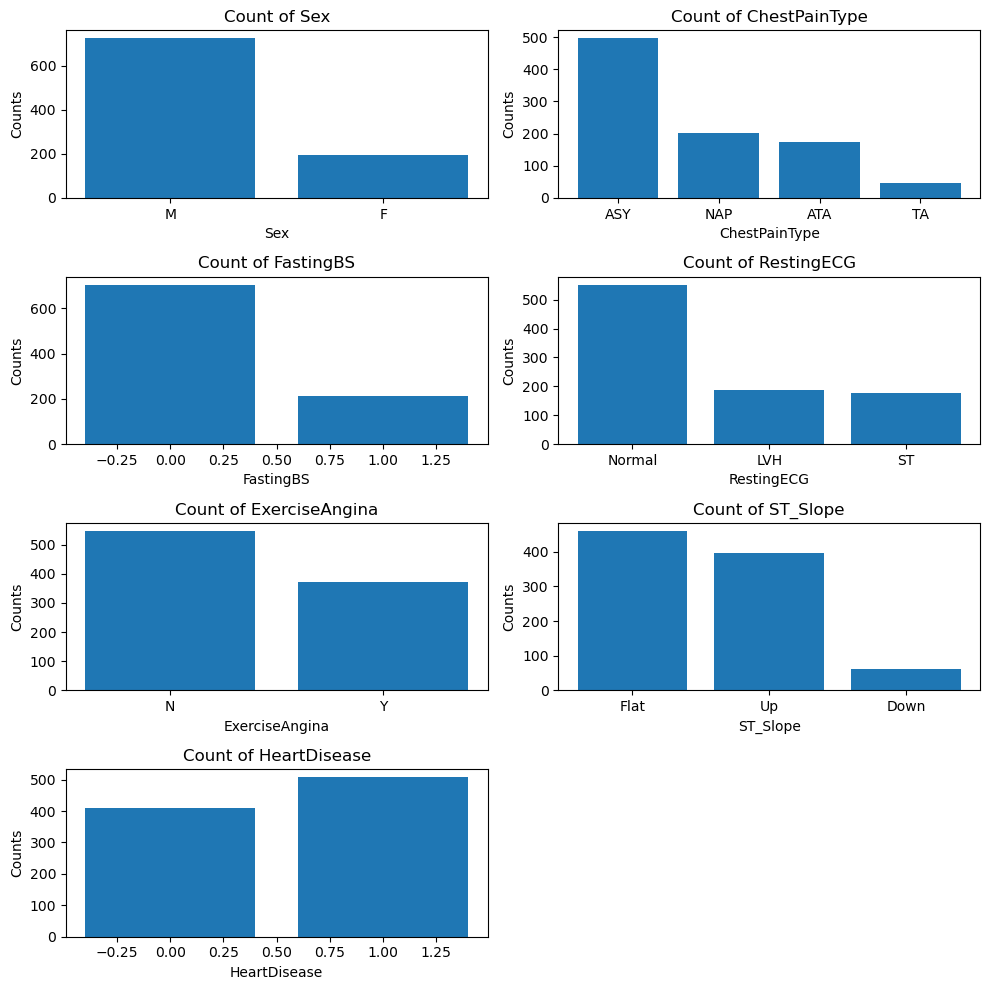

In [3]:
# Create a list of categorical columns including HeartDisease and FastingBS 

cat =  ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

#We are going to set the size of our grid 
fig, axes = plt.subplots(4, 2, figsize =(10,10)) 

#Flattening axes for to make it plots to loop through 
axes = axes.flatten()

for i, col in enumerate(cat): 
    values = heart[col].value_counts()
    axes[i].bar(values.index, values.values)
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')
    
#Remove last blank subplot 
fig.delaxes(axes[-1])

#Spruce up our figures 
plt.tight_layout()
plt.show()

From first glance of this dataset, our dataset is mostly comprised of male patients. This can skew our results when trying to generalize to the general population. 

Now it would be helpful to view all these categorical columns, but group them by HeartDisease to detetermine if any trends may seem more clear to us. 

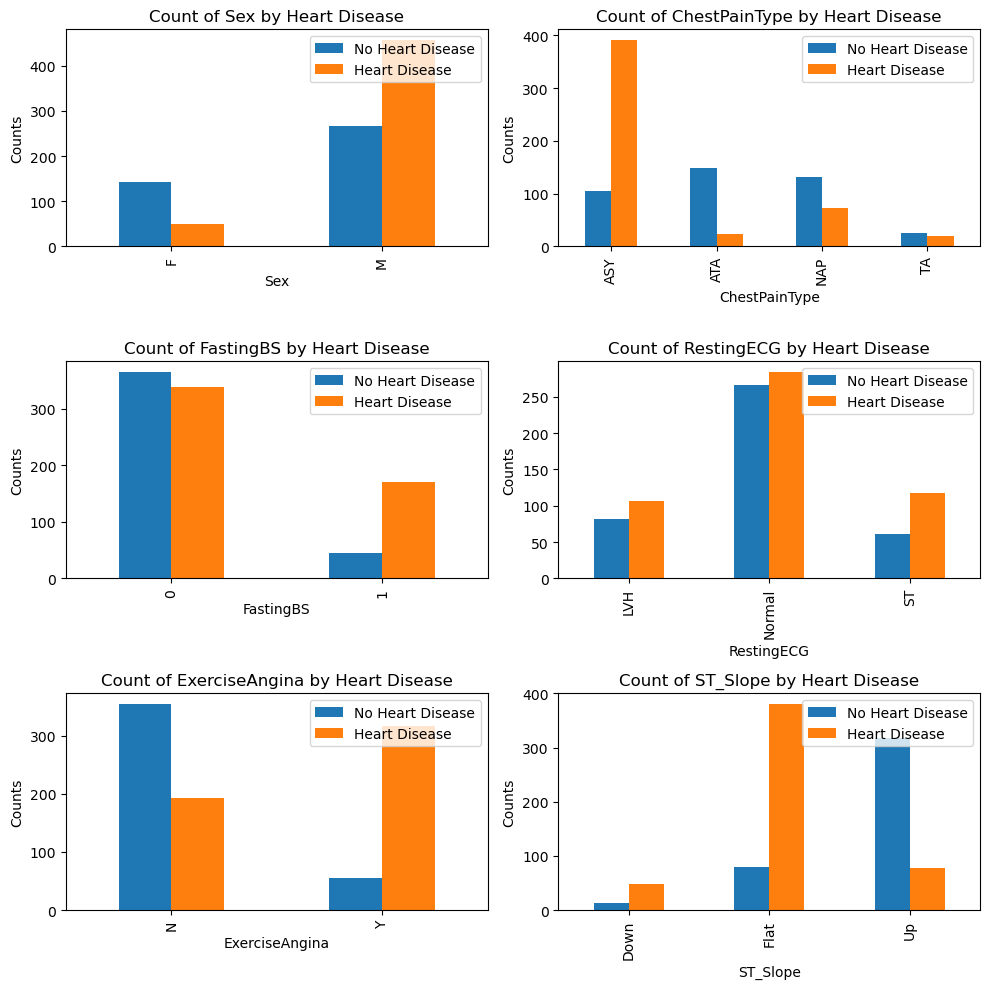

In [4]:
cat =  ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

#We are going to set the size of our grid 
fig, axes = plt.subplots(3, 2, figsize =(10,10)) 

#Flattening axes for to make it plots to loop through 
axes = axes.flatten()

for i, col in enumerate(cat): 
    values = heart.groupby(['HeartDisease', col]).size().reset_index(name='Counts')
    pivot_table = values.pivot(index=col, columns='HeartDisease', values='Counts')
    pivot_table.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Count of {col} by Heart Disease')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')
    axes[i].legend(labels=['No Heart Disease', 'Heart Disease'], loc = 'upper right')


#Spruce up our figures 
plt.tight_layout()
plt.show()

### Data Cleaning

It looks like half of the population has heart disease and half does not which is good for when we have to train our model later. Additionally, it looks like the majority of those that have heart disease have asymptomatic chest pain.

Now that we have been able to identify general trends, we have a few columns to clean. Earlier we identified that RestingBP and Cholesterol had values of 0. This data seems erroneous and can unnecessarily skew our distribution. 

Therefore, we will resolve this by replacing those values with the median of its respective column grouped by Heart Disease. 

In [5]:
print(f"Rows that have 0 for RestingBP: {(heart['RestingBP'] == 0).sum()}")
print(f"Rows that have 0 for Cholesterol: {(heart['Cholesterol'] == 0).sum()}")

Rows that have 0 for RestingBP: 1
Rows that have 0 for Cholesterol: 172


In [6]:
# Make copy of heart df 
heart_copy = heart.copy()

#Replace values of 0 with th median 
heart_copy['RestingBP'] = heart_copy.groupby('HeartDisease')['RestingBP'].apply(lambda x: x.replace(0, x.median()))


#Replace values of 0 with th median 
heart_copy['Cholesterol'] = heart_copy.groupby('HeartDisease')['Cholesterol'].apply(lambda x: x.replace(0, x.median()))

### Feature Exploration

We have spent a considerable amount of time exploring and cleaning our data. Now we are ready for diving deeper into various features to understand which features can help us best predict patients likely to develop heart disease. 

We are going to convert all of the categorical variables into dummy variables and inspect their respective correlation with HeartDisease.

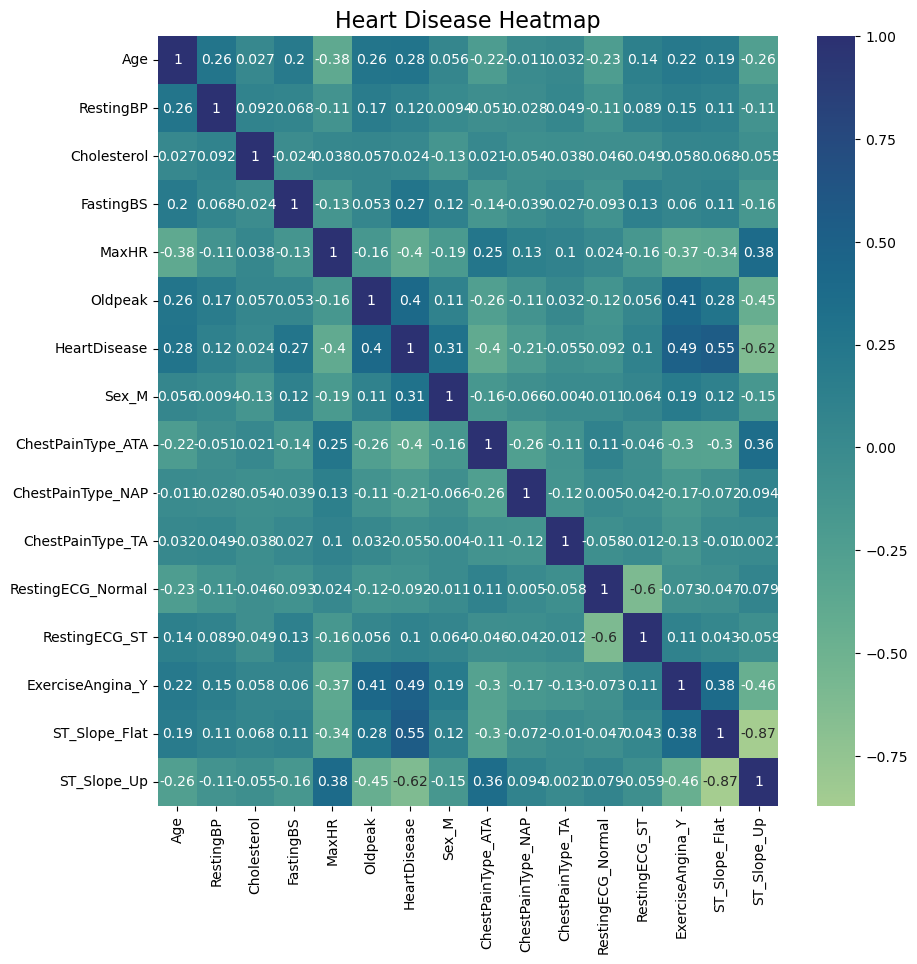

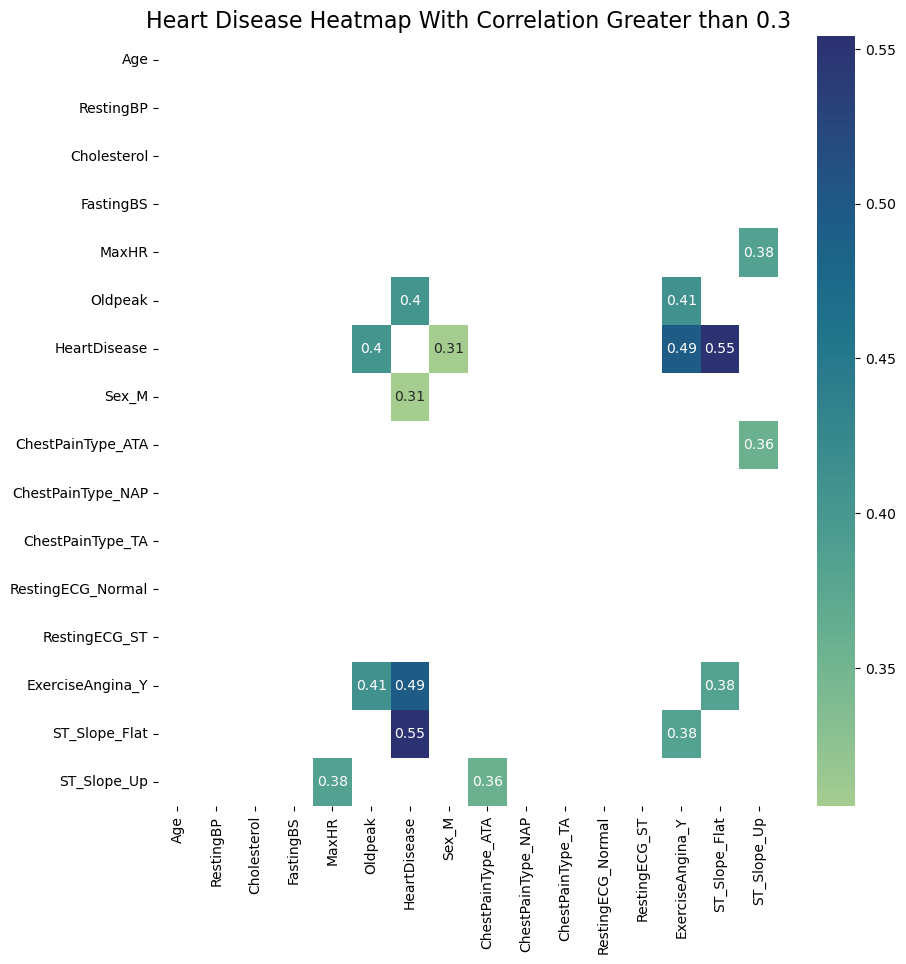

In [7]:
#All categorical variables into dummy variables 

# Convert categorical variable into dummy variables
heart_copy = pd.get_dummies(heart_copy, drop_first=True)

#Plotting the correlation of categorical variables on a heat map 
heart_corr = heart_copy.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(heart_corr, cmap="crest", annot = True)
plt.title("Heart Disease Heatmap", fontsize=16)
plt.show()

#Identifying which values are positively correlated
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(heart_corr[(heart_corr > 0.3) & (heart_corr < 1)], cmap="crest", annot = True)
plt.title("Heart Disease Heatmap With Correlation Greater than 0.3", fontsize=16)
plt.show()

### Single Feature Classifier 

Based on the results from the heat map the features that we are interested in are OldPeak, Sex_M, ExerciseAngina_Y, and ST_Slope_Flat. 

With these features we are going to build a single feature classifier with each of our features at a time. 

In [8]:
#We are going to split into a training and validation set
X = heart_copy.drop('HeartDisease', axis=1)
y = heart_copy['HeartDisease']

features = ['Oldpeak', 'Sex_M', 'ExerciseAngina_Y', 'ST_Slope_Flat']

#Let's experiment with test sizes 

tests = [0.1, 0.15, 0.2, 0.25, 0.3]

all_results  = {} 
        
for test in tests: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test, random_state = 10)

    #Create an instance of k-NN classifier 

    knn = KNeighborsClassifier(n_neighbors = 3)

    current_results = {} 

    for feature in features: 
        knn.fit(X_train[[feature]], y_train)
        val_score = knn.score(X_val[[feature]], y_val)
        current_results[feature] = round(val_score, 2)
    
    all_results[test] = current_results 
    
print(pd.DataFrame(all_results))

                  0.10  0.15  0.20  0.25  0.30
Oldpeak           0.62  0.59  0.65  0.72  0.65
Sex_M             0.54  0.62  0.61  0.61  0.54
ExerciseAngina_Y  0.67  0.56  0.70  0.53  0.72
ST_Slope_Flat     0.73  0.75  0.76  0.53  0.75


We tried experimenting with the various test sizes to determine which size would be provide the highest accuracy. 

Here are some observations for our findings: 

- Depending on the feature that is being test, the best test size for accuracy will vary. For example for Oldpeak the best test size would be 0.25, while for Sex_M, the best test size would be 0.15. 
- Across all tests, ST_Slope_Flat has the highest accuracy.

As a result of these findings, we are going to set our test size to be 0.2. 

Next, we are going to determine which value of number of neighbors would yield the highest accuracy. 

In [9]:
neighbors = [1, 3, 5, 7, 8, 9, 10, 15]

all_results  = {} 
        
for neighbor in neighbors: 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10)

    #Create an instance of k-NN classifier 

    knn = KNeighborsClassifier(n_neighbors = neighbor)

    current_results = {} 

    for feature in features: 
        knn.fit(X_train[[feature]], y_train)
        val_score = knn.score(X_val[[feature]], y_val)
        current_results[feature] = round(val_score, 2)
    
    all_results[neighbor] = current_results 
    
print(pd.DataFrame(all_results))

                    1     3     5     7     8     9     10    15
Oldpeak           0.67  0.65  0.68  0.68  0.66  0.68  0.69  0.69
Sex_M             0.53  0.61  0.61  0.47  0.47  0.61  0.61  0.61
ExerciseAngina_Y  0.70  0.70  0.70  0.70  0.70  0.70  0.70  0.70
ST_Slope_Flat     0.53  0.76  0.76  0.76  0.76  0.76  0.76  0.76


It doesn't really look like that as we increase the number of neighbors, the accuracy improves by a large margin. Therefore, we can set our n_neighbors to 5. 

Thus based on our experimentation, the best model should have a test size of 0.2 and n_neighbors of 5. 

Now that we have determined what our hyperparameters are, we can create a model that uses all of the features selected together. 

However, before we do that, we have to ensure we normalize our selected features. 

In [10]:
#We are going to split into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.20, random_state=10)

# We are going to fit and transform our features in the training set
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

# Now we will transform same features in the validation set
X_val_scaled = scaler.transform(X_val)

# Fit the model on scaled features using n_neighbors = 5 
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)

#Determine accuracy 
accuracy = knn.score(X_val_scaled, y_val)

print(accuracy)

0.8260869565217391


We were able to receive an accuracy of ~83% using our selected and normalized features. This was higher than any of the single feature models we created previously. 

However, it is not that much of an improvement, therefore we still have room for improvements to make. We can use GridSearchCV to determine the best combination of parameters and hyperparameters for our model. 


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.20, random_state=10)

# We are going to fit and transform our features in the training set
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

grid_params = {
'n_neighbors':range(1,10),
'weights': ['uniform', 'distance'],
'metric': ['minkowski', 'manhattan']
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator=knn, param_grid=grid_params, scoring='accuracy')

knn_grid.fit(X_train_scaled, y_train)

best_score = knn_grid.best_score_
best_params = knn_grid.best_params_
best_estimator = knn_grid.best_estimator_


print(best_score)
print(best_params)
print(best_estimator)

0.8473953965147702
{'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=9)


#### Testing Model on Test Set 

In [12]:
X_test_scaled = scaler.transform(X_test)
accuracy = knn_grid.best_estimator_.score(X_test_scaled, y_test)
print(f"Model Accuracy on test set: {accuracy}") 

Model Accuracy on test set: 0.8260869565217391


Our accuracy actually fell after using the best estimator. This may mean the model may have overfit to the training data. 


### Final Conclusions 

Our model had an accuracy of 82.6%. For future improvement, we can possibly consider using other features from our data that we may not have previously considered. 

From this analysis, we were able to explore, clean, and develop a model from our dataset in order to predict
which patients are likelier to develop heart disease with an 82.6% accuracy. 

While possible to use this predictive model for highlighting patients who may develop heart disease there are a few pros and cons we should consider about using this in a real-world setting. 

- Pros 
    - Early detection and proactive treatment for heart disease patients 
    - Cost savings due to proactive treatment for both patient and healthcare facility 
    
- Cons 
    - This dataset does not generalize to all populations and the accuracy can change based on population 
    - As a result, accuracy may be wrong and can lead to unnecessary treatment for patients who will not develop heart disease 
    
    
All in all, this exercise can be a nice starting point for more testing and tuning for better detection.

